In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
#install.packages("tidyr")

NULL


In [3]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [7]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [10]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [11]:
%%R
mdf = psmelt(physeq)

### Phylogenetic overview

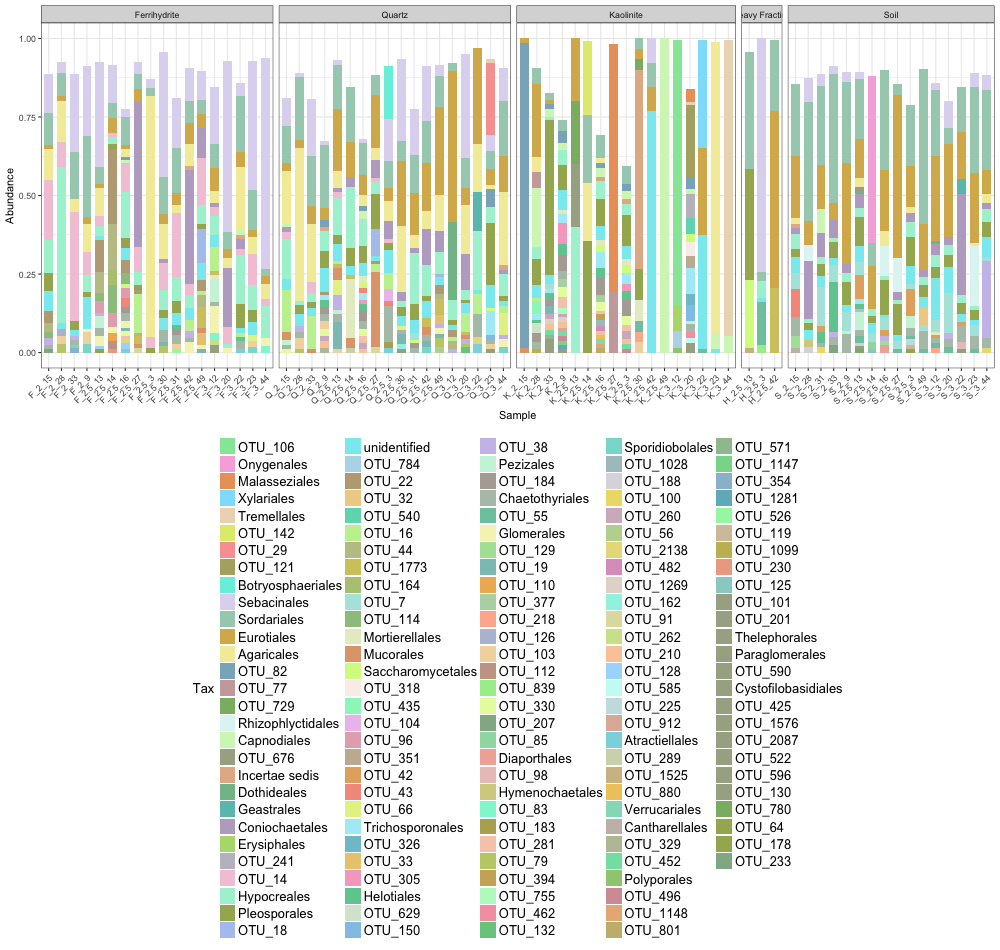

In [18]:
%%R -w 1000 -h 950

cutoff = 0.01
totabund = 1

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, d.plot$OTU, paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Sample, Order, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
#    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.text.x = element_text(angle=45, hjust=1), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

### Looking at the weird Kaolinite sample, taking out Malasseziales
Paraconiothyrium is a fruit tree leaf microbe - fine.  
Still, it's weirdly undiverse - sample probably not good.

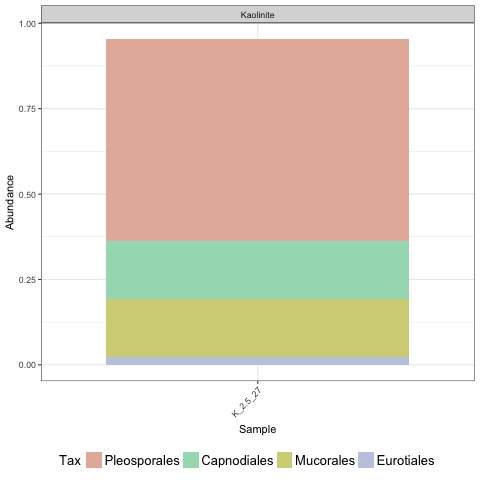

In [21]:
%%R
K27 = prune_samples(sample="K_2.5_27",physeq)
K27 = subset_taxa(K27, Order!= "Malasseziales")


mdf = psmelt(K27)

cutoff = 0.01
totabund = 1

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, d.plot$OTU, paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Sample, Order, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
#    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.text.x = element_text(angle=45, hjust=1), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

### Phylum relative abundance

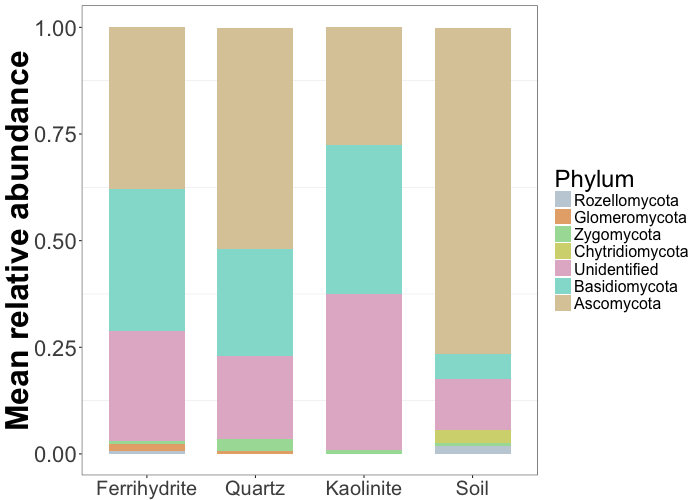

In [19]:
%%R -w 700 -h 500

cutoff = 0.005
totabund = 1500

d.plot = mdf %>%
#    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    group_by(Trtmt,Month, Phylum, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Phylum) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Phylum)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))
#d.plot$Month = as.factor(d.plot$Month)
#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))


d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title="Phylum",ncol = 1, reverse=TRUE))

p = p + theme_bw()

p = p + ylab("Mean relative abundance")

p = p + theme(
    axis.title.x = element_blank(), axis.text.x = element_text(size=20), 
    axis.title.y = element_text(size=32, face='bold', vjust=1),
    axis.text.y = element_text(size=22),
    legend.position="right", legend.text=element_text(size=16), legend.title=element_text(size=24),
    panel.grid.major= element_blank())
p

In [33]:
%%R
#ggsave(filename="RelabundPhylumITS.jpg", p, width=11.4, height=8.6)

NULL


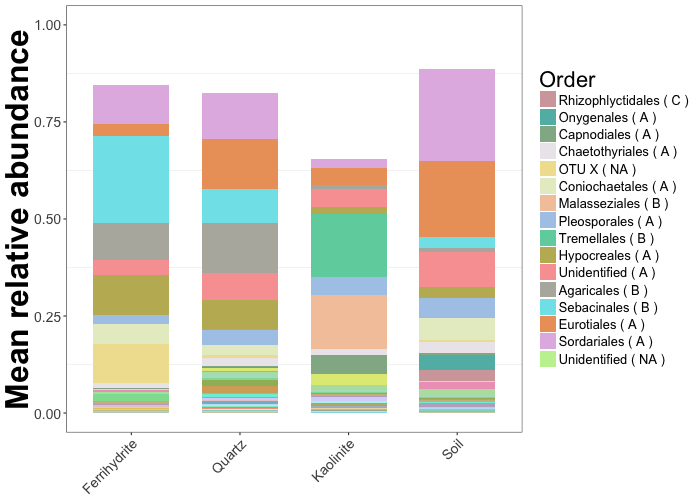

In [20]:
%%R -w 700 -h 500

cutoff = 0
totabund = 1500

d.plot = mdf %>%
#    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))%>%
    mutate(PhylumLetter = substring(Phylum,1,1))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, ifelse(d.plot$OTU=="OTU_14","OTU X","Unidentified"), paste(d.plot$Order))
d.plot$Order = ifelse(d.plot$Order=="unidentified"|d.plot$Order=="Incertae sedis", "Unidentified", paste(d.plot$Order))
d.plot$Order = paste(d.plot$Order,"(",d.plot$PhylumLetter,")")

d.plot = d.plot %>%
    group_by(Trtmt,Month, Order, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Order) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Order)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

#d.plot$Month = as.factor(d.plot$Month)
#d.plot$Month = ifelse(d.plot$Month==2.0, "1 Month", ifelse(d.plot$Month==2.5, "1.5 Months", "2 Months"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

N=16
Orders=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]

p = p + scale_fill_manual(breaks=Orders,values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title = "Order", ncol = 1, reverse=TRUE))

p = p + theme_bw()
p = p + ylab("Mean relative abundance")
p = p + ylim(0,1.00)
p = p + theme(
    axis.title.x = element_blank(), 
    axis.text.x = element_text(size = 14, angle = 45, hjust=1),
    axis.text.y = element_text(size = 14),
    axis.title.y = element_text(size=32, face="bold", vjust=1),
    legend.position="right", legend.text=element_text(size=13), 
    legend.title=element_text(size=22),
    #legend.text=element_text(size=16),
    panel.grid.major= element_blank())

p

In [14]:
%%R
#ggsave(filename="RelabundOrderITS.Argonne.jpg", p, width=6, height=8.6)

### Presenting as boxplots, not bar graphs, for first resubmission

In [90]:
%%R
cutoff = 0
totabund = 1500
nTax = 10
# Setting parameters

d = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
# Including only those where total sample size was sufficient
    mutate(Abundance = Abundance / sum(Abundance))%>%
    mutate(PhylumLetter = substring(Phylum,1,1))
# Creating a code for the phylum

d$Order = ifelse(is.na(d$Order)==TRUE, ifelse(d$OTU=="OTU_14","OTU X","Unidentified"), paste(d$Order))
d$Order = ifelse(d$Order=="unidentified"|d$Order=="Incertae sedis", "Unidentified", paste(d$Order))
d$Order = paste(d$Order,"(",d$PhylumLetter,")")
# Integrating the phylum letter into the order name
head(d$Order)

[1] "Sebacinales ( B )" "Sebacinales ( B )" "Eurotiales ( A )" 
[4] "Sordariales ( A )" "Onygenales ( A )"  "Sordariales ( A )"


In [91]:
%%R
d.plot = d %>%
    filter(Month!=2.0)%>%
    group_by(Order) %>%
    summarize(Abundance = sum(Abundance))%>%
    arrange(-Abundance)
Porder=d.plot$Order
Porder[1:20]
# Ordering the orders roughly in order of total abundance

 [1] "Unidentified ( NA )"     "Eurotiales ( A )"       
 [3] "Sebacinales ( B )"       "Sordariales ( A )"      
 [5] "Agaricales ( B )"        "Hypocreales ( A )"      
 [7] "Unidentified ( A )"      "Coniochaetales ( A )"   
 [9] "Pleosporales ( A )"      "OTU X ( NA )"           
[11] "Tremellales ( B )"       "Malasseziales ( B )"    
[13] "Chaetothyriales ( A )"   "Onygenales ( A )"       
[15] "Mucorales ( Z )"         "Rhizophlyctidales ( C )"
[17] "Unidentified ( R )"      "Glomerales ( G )"       
[19] "Mortierellales ( Z )"    "Dothideales ( A )"      


In [92]:
%%R

# Setting up the data so we don't have to re-run each time

cutoff = 0
nphyla = 12

UnID = c("Unidentified ( A )", "Unidentified ( NA )", "Unidentified ( R )","Tremellales ( B )","Malasseziales ( B )","Onygenales ( A )","Rhizophlyctidales ( C )")
Porder=Porder[(!(Porder %in% UnID))]


Porder = Porder[1:nphyla]
# Selects only the Phyla from the top nphyla (usu. 10)


# For a given sample, I want to make sure that if a phylum from my list is not present,
# we assign it a value of zero. I guess we need to get all the sample IDs

d.plot = d %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Order, Sample) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Order %in% Porder)%>%
    arrange(-Abundance)

d.plot$Order = factor(d.plot$Order, levels = Porder)
d.plot = d.plot[with(d.plot, order(d.plot$Order)),]
# Changing labels, setting orders, etc.

head(d.plot)

Source: local data frame [6 x 3]
Groups: Order [1]

             Order   Sample Abundance
            <fctr>    <chr>     <dbl>
1 Eurotiales ( A ) S_2.5_27 0.5189900
2 Eurotiales ( A )   Q_3_12 0.4805106
3 Eurotiales ( A )    S_2_9 0.3197298
4 Eurotiales ( A )   Q_3_22 0.3032780
5 Eurotiales ( A )   S_3_20 0.2964691
6 Eurotiales ( A ) Q_2.5_49 0.2779475


In [93]:
%%R
d.plot2 = d.plot %>%
    tidyr::expand(Sample, Order)%>%
    left_join(d.plot)
d.plot2[is.na(d.plot2)] = 0
SampTrtmt = unique(mdf[,colnames(mdf)%in% c("Sample","Trtmt")])
d.plot = left_join(d.plot2,SampTrtmt, by="Sample")
d.plot$Trtmt = factor(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

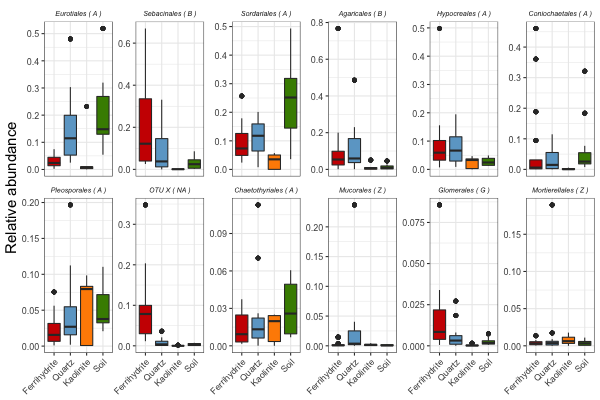

In [95]:
%%R -w 600 -h 400

p = ggplot(d.plot, aes(Trtmt, Abundance, fill = Trtmt))

p = p + geom_boxplot()

p = p + facet_wrap(~Order, scales = "free_y",nrow=2)

p = p + scale_fill_manual(values=c("red3","skyblue3","darkorange","chartreuse4","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=7, face="italic"), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p

In [96]:
%%R
ggsave(filename="RelabundOrderITS2MonthsBox.revised.jpg", p, width=8, height=4)

In [108]:
%%R
dim(d.plot)

[1] 7788    4


In [98]:
%%R
for(i in Porder){
    a = d.plot%>%
        filter(Order==i)
    anova=aov(a$Abundance~a$Trtmt)
    Tukey=TukeyHSD(anova)
    print(i)
    print(summary(anova))
    print(Tukey)}

[1] "Eurotiales ( A )"
             Df Sum Sq Mean Sq F value Pr(>F)    
a$Trtmt       3  2.938  0.9794   109.9 <2e-16 ***
Residuals   645  5.750  0.0089                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = a$Abundance ~ a$Trtmt)

$`a$Trtmt`
                              diff         lwr         upr     p adj
Quartz-Ferrihydrite     0.10800106  0.08417643  0.13182568 0.0000000
Kaolinite-Ferrihydrite  0.02639577 -0.01122212  0.06401366 0.2707426
Soil-Ferrihydrite       0.16390488  0.13928232  0.18852744 0.0000000
Kaolinite-Quartz       -0.08160528 -0.11938565 -0.04382492 0.0000002
Soil-Quartz             0.05590382  0.03103374  0.08077391 0.0000001
Soil-Kaolinite          0.13750911  0.09922055  0.17579767 0.0000000

[1] "Sebacinales ( B )"
             Df Sum Sq Mean Sq F value Pr(>F)    
a$Trtmt       3  3.901  1.3004   92.34 <2e-16 ***
Residuals   645  9.084

## Older version of stacked bars

In [24]:
%%R

cutoff = 0
totabund = 1500
nTax = 10
# Setting parameters

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
# Including only those where total sample size was sufficient
    mutate(Abundance = Abundance / sum(Abundance))%>%
    mutate(PhylumLetter = substring(Phylum,1,1))
# Creating a code for the phylum

d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, ifelse(d.plot$OTU=="OTU_14","OTU X","Unidentified"), paste(d.plot$Order))
d.plot$Order = ifelse(d.plot$Order=="unidentified"|d.plot$Order=="Incertae sedis", "Unidentified", paste(d.plot$Order))
d.plot$Order = paste(d.plot$Order,"(",d.plot$PhylumLetter,")")
# Integrating the phylum letter into the order name

d.plot = d.plot %>%
    filter(Month!=2.0)%>%
    group_by(Sample,Order)%>%
    mutate(Abundance = sum(Abundance))%>%
    group_by()%>%
    select(Sample,Trtmt,Order,Abundance)
# Only looking at months 2.5 and 3

colnames(d.plot) <- c("Sample", "Trtmt", "Tax", "Abundance")

d.plot = d.plot %>%
    expand(Sample, Tax) %>%
    left_join(d.plot)%>%
    group_by(Sample, Tax, Trtmt)%>%
    summarise(Abundance = sum(Abundance, na.rm=TRUE))
# Taking the data, and making all possible combinations of sample, phylum, and treatment
# Then, we match up our actual data with our abundance counts, etc.
# And, we don't want there to be NAs, so we sum the total for each possibility

# But we also need non-presences to be counted.

SampTrtmt = na.omit(unique(d.plot[c("Sample", "Trtmt")]))
# Creating a list of sample IDs matched with their treatment

d.plot = merge(d.plot[,c(1,2,4)], SampTrtmt, by="Sample")
# Merging the two tables, but forgetting the old Trtmt column

In [30]:
%%R
head(d.plot)

    Sample                         Tax Abundance        Trtmt
1 F_2.5_13         Acarosporales ( A )  0.000000 Ferrihydrite
2 F_2.5_13            Agaricales ( B )  6.446826 Ferrihydrite
3 F_2.5_13      Agaricostilbales ( B )  0.000000 Ferrihydrite
4 F_2.5_13      Arachnomycetales ( A )  0.000000 Ferrihydrite
5 F_2.5_13 Archaeorhizomycetales ( A )  0.000000 Ferrihydrite
6 F_2.5_13       Archaeosporales ( G )  0.000000 Ferrihydrite


In [51]:
%%R

TaxOrder = d.plot %>%
    group_by(Tax,Trtmt)%>%
    mutate(meanabund = mean(Abundance))%>%
    group_by(Tax)%>%
    mutate(Totabund=sum(meanabund))%>%
    group_by()%>%
    distinct(Tax,Totabund)%>%
    arrange(-Totabund)%>%
    select(Tax)
# Making a list with the taxa in order of abundance

d = d.plot %>%
    group_by(Tax) %>%
    summarize(Abundance = sum(Abundance))
Torder = na.omit(d$Tax[order(-d$Abundance)])
# Remove NAs and sort by abundance
UnID = c("Unidentified ( A )", "Unidentified ( NA )","Tremellales ( B )")
Torder=Torder[(!(Torder %in% UnID))]
# Cut out the unidentified Orders, and a weird Tremellales that is super abundant in one Kaolinite sample
Torder = Torder[1:nTax]
# Ordering the Orders roughly in order of total abundance

d.plot = d.plot %>%
    filter(d.plot$Tax %in% Torder)
# Selecting only the most abundant Orders

d.plot$Tax = factor(d.plot$Tax, levels = Torder)
d.plot = d.plot[with(d.plot, order(d.plot$Tax)),]
# Ordering the Tax factors

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
# Ordering the mineral factors

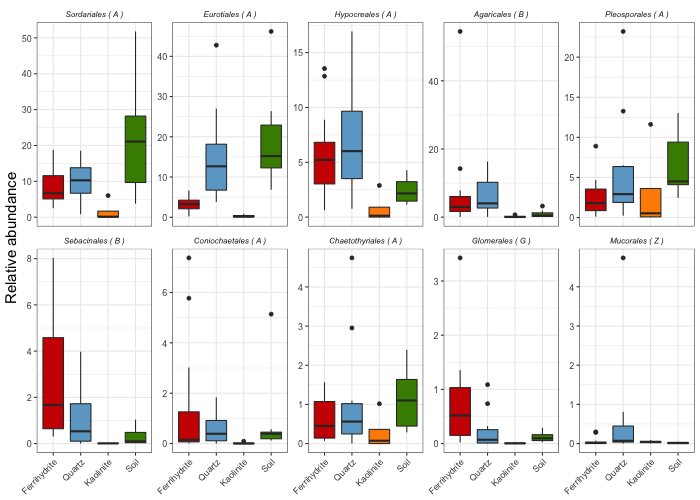

In [57]:
%%R  -w 700 -h 500

p = ggplot(d.plot, aes(Trtmt, Abundance, fill = Trtmt))

p = p + geom_boxplot()

p = p + facet_wrap(~Tax, scales = "free_y",nrow=2)

p = p + scale_fill_manual(values=c("red3","skyblue3","darkorange","chartreuse4","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=8, face="italic"), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p

In [58]:
%%R
ggsave(filename="RelabundOrderITS2MonthsBox.jpg", p, width=7, height=4)

In [29]:
%%R
m = SampTrtmt%>%
    group_by(Trtmt)%>%
    summarize(count=n())
m

Source: local data frame [4 x 2]

         Trtmt count
1 Ferrihydrite    14
2    Kaolinite     4
3       Quartz    14
4         Soil    10


In [30]:
%%R
for(i in Torder){
    a = d.plot%>%
        filter(Tax==i)
    anova=aov(a$Abundance~a$Trtmt)
    Tukey=TukeyHSD(anova)
    print(i)
    print(summary(anova))
    print(Tukey)}

[1] "Sordariales ( A )"
            Df Sum Sq Mean Sq F value   Pr(>F)    
a$Trtmt      3   1573   524.4   7.542 0.000446 ***
Residuals   38   2642    69.5                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = a$Abundance ~ a$Trtmt)

$`a$Trtmt`
                            diff        lwr       upr     p adj
Quartz-Ferrihydrite     1.828229  -6.638664 10.295121 0.9374597
Kaolinite-Ferrihydrite -6.672304 -19.372643  6.028035 0.5002327
Soil-Ferrihydrite      13.268715   3.993698 22.543731 0.0024307
Kaolinite-Quartz       -8.500533 -21.200872  4.199807 0.2900111
Soil-Quartz            11.440486   2.165470 20.715503 0.0104820
Soil-Kaolinite         19.941019   6.688235 33.193802 0.0013686

[1] "Eurotiales ( A )"
            Df Sum Sq Mean Sq F value   Pr(>F)    
a$Trtmt      3   2175   725.0   10.22 4.53e-05 ***
Residuals   38   2696    70.9                     
-

### Making box plots and stats for Phylum level for Plant Path seminar

In [91]:
%%R

cutoff = 0
totabund = 1500
nTax = 6
# Setting parameters

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
# Including only those where total sample size was sufficient
    mutate(Abundance = Abundance / sum(Abundance))%>%
    mutate(PhylumLetter = substring(Phylum,1,1))
# Creating a code for the phylum

#d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, ifelse(d.plot$OTU=="OTU_14","OTU X","Unidentified"), paste(d.plot$Order))
#d.plot$Order = ifelse(d.plot$Order=="unidentified"|d.plot$Order=="Incertae sedis", "Unidentified", paste(d.plot$Order))
#d.plot$Order = paste(d.plot$Order,"(",d.plot$PhylumLetter,")")
# Integrating the phylum letter into the order name

d.plot = d.plot %>%
    filter(Month!=2.0)%>%
    select(Sample,Trtmt,Phylum,Abundance)
# Only looking at months 2.5 and 3

colnames(d.plot) <- c("Sample", "Trtmt", "Tax", "Abundance")

d.plot = d.plot %>%
    expand(Sample, Tax) %>%
    left_join(d.plot)%>%
    group_by(Sample, Tax, Trtmt)%>%
    summarise(Abundance = sum(Abundance, na.rm=TRUE))
# Taking the data, and making all possible combinations of sample, phylum, and treatment
# Then, we match up our actual data with our abundance counts, etc.
# And, we don't want there to be NAs, so we sum the total for each possibility

# But we also need non-presences to be counted.

SampTrtmt = na.omit(unique(d.plot[c("Sample", "Trtmt")]))
# Creating a list of sample IDs matched with their treatment

d.plot = merge(d.plot[,c(1,2,4)], SampTrtmt, by="Sample")
# Merging the two tables, but forgetting the old Trtmt column

In [92]:
%%R
head(d.plot)

    Sample             Tax   Abundance        Trtmt
1 F_2.5_13      Ascomycota 0.189463928 Ferrihydrite
2 F_2.5_13   Basidiomycota 0.428319431 Ferrihydrite
3 F_2.5_13        Cercozoa 0.000000000 Ferrihydrite
4 F_2.5_13 Chytridiomycota 0.001315514 Ferrihydrite
5 F_2.5_13   Glomeromycota 0.032110503 Ferrihydrite
6 F_2.5_13   Rozellomycota 0.005172362 Ferrihydrite


In [93]:
%%R
TaxOrder = d.plot %>%
    group_by(Tax,Trtmt)%>%
    mutate(meanabund = mean(Abundance))%>%
    group_by(Tax)%>%
    mutate(Totabund=sum(meanabund))%>%
    group_by()%>%
    arrange(-Totabund)%>%
    distinct(Tax,Totabund)%>%
    select(Tax)
# Making a list with the taxa in order of abundance

d = d.plot %>%
    group_by(Tax) %>%
    summarize(Abundance = sum(Abundance))
Torder = na.omit(d$Tax[order(-d$Abundance)])
# Remove NAs and sort by abundance
UnID = c("unidentified",NA)
Torder=Torder[(!(Torder %in% UnID))]
# Cut out the unidentified Orders, and a weird Tremellales that is super abundant in one Kaolinite sample
Torder = Torder[1:nTax]
# Ordering the Orders roughly in order of total abundance

d.plot = d.plot %>%
    filter(d.plot$Tax %in% Torder)
# Selecting only the most abundant Orders

d.plot$Tax = factor(d.plot$Tax, levels = Torder)
d.plot = d.plot[with(d.plot, order(d.plot$Tax)),]
# Ordering the Tax factors

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
# Ordering the mineral factors

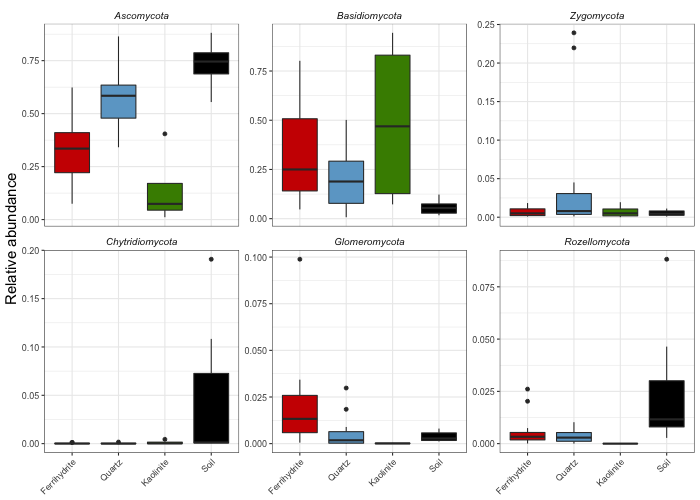

In [94]:
%%R  -w 700 -h 500

p = ggplot(d.plot, aes(Trtmt, Abundance, fill = Trtmt))

p = p + geom_boxplot()

p = p + facet_wrap(~Tax, scales = "free_y",nrow=2)

p = p + scale_fill_manual(values=c("red3","skyblue3","chartreuse4","black","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=10, face="italic"), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p

In [97]:
%%R
ggsave(filename="RelabundPhylumITS2MonthsBox.jpg", p, width=6, height=4)

In [96]:
%%R
for(i in Torder){
    a = d.plot%>%
        filter(Tax==i)
    anova=aov(a$Abundance~a$Trtmt)
    Tukey=TukeyHSD(anova)
    print(i)
    print(summary(anova))
    print(Tukey)}

[1] "Ascomycota"
            Df Sum Sq Mean Sq F value   Pr(>F)    
a$Trtmt      3 1.4764  0.4921   23.62 8.48e-09 ***
Residuals   38 0.7918  0.0208                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = a$Abundance ~ a$Trtmt)

$`a$Trtmt`
                             diff          lwr          upr     p adj
Quartz-Ferrihydrite     0.2201152  0.073544259  0.366686209 0.0014000
Kaolinite-Ferrihydrite -0.2105815 -0.430437913  0.009275013 0.0646886
Soil-Ferrihydrite       0.3894110  0.228850578  0.549971496 0.0000007
Kaolinite-Quartz       -0.4306967 -0.650553147 -0.210840221 0.0000336
Soil-Quartz             0.1692958  0.008735344  0.329856262 0.0354357
Soil-Kaolinite          0.5999925  0.370572622  0.829412353 0.0000001

[1] "Basidiomycota"
            Df Sum Sq Mean Sq F value  Pr(>F)   
a$Trtmt      3 0.7373 0.24576   5.392 0.00343 **
Residuals   38 1.7319 0.

### Other notes

In [227]:
%%R
cutoff = 0
totabund = 3000

d.plot = mdf %>%
    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, ifelse(d.plot$OTU=="OTU_14","OTU X","Unidentified"), paste(d.plot$Order))
d.plot$Order = ifelse(d.plot$Order=="unidentified"|d.plot$Order=="Incertae sedis", "Unidentified", paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Trtmt,Month, Order, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Order) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Order)%>%
    summarize(Abundance = mean(Abundance))
d.plot[d.plot$Order=="OTU X",]

Source: local data frame [3 x 3]
Groups: Trtmt

         Trtmt Order   Abundance
1 Ferrihydrite OTU X 0.098778613
2       Quartz OTU X 0.010611827
3         Soil OTU X 0.003240036


This shows the relative abundance of each taxon, out of the total pool in each sample.  
We can see that Glomerales are relatively enriched compared to the soil.  
Onygenales in Soil could be contamination or perhaps sheep droppings?  Matches Emmonsia, which is a saptrotroph, and can live in the soil.  
OTU_14 matches Dothideomycetes or another Ascomycete at 89%

In [405]:
%%R
#tax = data.frame(tax_table(physeq))
#tax.na = row.names(tax[is.na(tax$Kingdom)==TRUE,])
#length(tax.na)
# There are 1005/2200 OTUs that we could not match in the UNITE db
physeq.na = subset_taxa(physeq, is.na(Kingdom) == TRUE)
otu_table(physeq.na)

OTU Table:          [1005 taxa and 73 samples]
                     taxa are columns
         OTU_64 OTU_2138 OTU_66 OTU_187 OTU_32 OTU_584 OTU_22 OTU_14 OTU_38
B__           0        0      0       0      0       0      0      0      0
F_2_15        0        1    168       0      0       0    692   3512    361
F_2_28       10        0     18       2      0       0     56   2549     58
F_2_33        7        1      0       0      0       0      0   4782    173
F_2_9         0        0      0       0      0       0      0    860      9
F_2.5_13      0        0      0       0      0       0   3405   1000    349
F_2.5_14      0        1      4       0      0       0  10673    510     68
F_2.5_16      1       34      0       0      0       0    125    269      7
F_2.5_27      1        1      1       0      0       0    924   5180    520
F_2.5_3       0        0      0       0      0       0     39    190      6
F_2.5_30      0        0      0       0      0       0      0   2389      0
F_2

###Looking at all OTUs

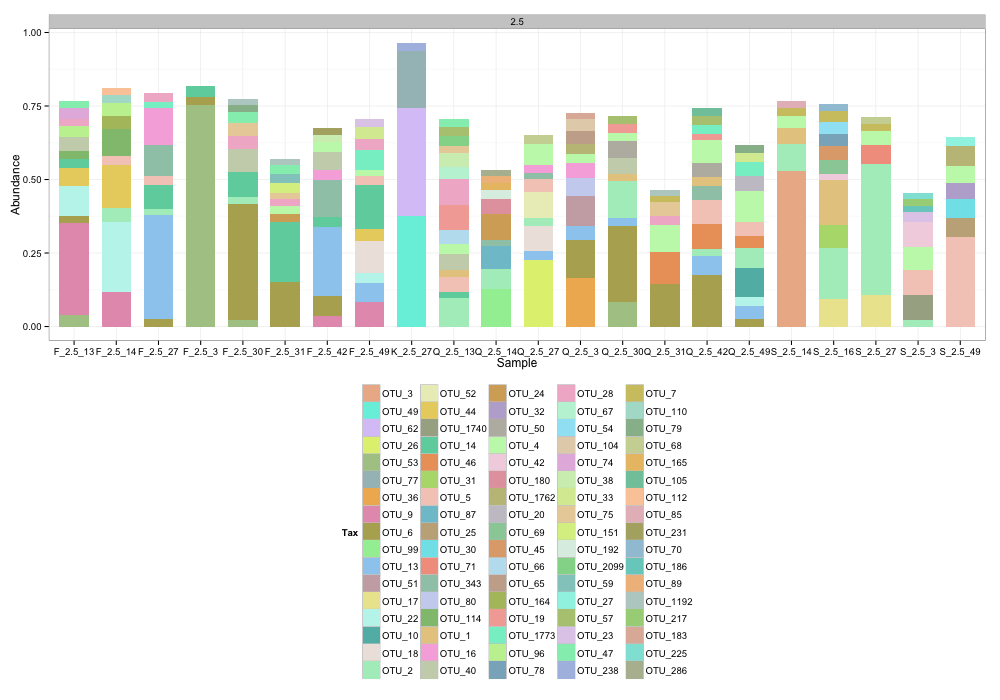

In [9]:
%%R -w 1000 -h 700

cutoff = 0.02
totabund = 3000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, OTU, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)


colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

d.plot$MonthName = ifelse(d.plot$Month==2,"1 Months",(ifelse(d.plot$Month==2.5, "1.5 Months","2 Months")))
d.plot$MonthName = paste(d.plot$MonthName)
# Creates a "strip" column of d with Months

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))


d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Month, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    #axis.text.x = element_blank(), 
    legend.position="bottom")

p

In [45]:
%%R -w 1000 -h 700

cutoff = 0.001
totabund = 3000

d.plot = mdf %>%
    filter(Sample == 70) %>%
    mutate(Relabund = Abundance / sum(Abundance)) %>%
    arrange(-Relabund)
d.plot[complete.cases(d.plot[,1:3]),c(1:3,21)]
#Looking at most abundant OTUs in sample 70, which has many not ID'd even to phylum.

          OTU Sample Abundance     Relabund
1      OTU_22     70     10581 2.470753e-01
2      OTU_44     70      6487 1.514769e-01
3       OTU_9     70      5286 1.234326e-01
4     OTU_114     70      4058 9.475773e-02
5      OTU_96     70      2045 4.775248e-02
6     OTU_164     70      2024 4.726211e-02
7       OTU_2     70      1845 4.308231e-02
8       OTU_5     70      1265 2.953882e-02
9     OTU_110     70      1151 2.687682e-02
10    OTU_112     70      1052 2.456509e-02
11     OTU_28     70       761 1.776999e-02
12    OTU_230     70       556 1.298307e-02
13      OTU_1     70       518 1.209574e-02
14     OTU_14     70       438 1.022767e-02
15     OTU_52     70       413 9.643900e-03
16     OTU_18     70       348 8.126095e-03
17    OTU_674     70       346 8.079393e-03
18    OTU_889     70       272 6.351430e-03
19    OTU_565     70       252 5.884413e-03
20   OTU_1773     70       226 5.277291e-03
21     OTU_10     70       173 4.039696e-03
22     OTU_40     70       163 3

OTU_22, OTU_44, OTU_96, OTU_114, OTU_112, OTU_110, OTU_164 does match an uncultured fungus clone ITS2 (OTU2087) from tallgrass prairie soil  (60% of total)  
Blasting OTU_22 full sequence gives same match, and possible match of sub(phylum)division Mucoromycotina - not yet clearly placed in the fungal tree. Not much hope of matching it, but at least it doesn't seem like a clear error or contamination. Includes saprobes, plant pathogens, and mycoparasites.  
OTU_9 matches Sebacinales  
OTU_2 matches Tallaromyces cellulolyticus or pinophilis  
OTU_103 matches an uncultured EMF clone G2_CH3 from Topanga state park grassland soil (near LA)

In [39]:
!grep -A -3 OTU_263 ../../SeqData/ITS.otus.fasta

>OTU_263
AAATAAAAATCGAGGTTTTTGCTGCCTTTTCGTGGTGAAGCTTCGGAGTTGGGTCGTCTTTACCTTTCGGTTAAGTGACC
TAAAATTTTTGTATGATATCTGAACGTATTTAAATTTATTTGGTACGTTTTGTAATATCAAATGTTTATTAGGTGTGGTC
ATCCTTATGATTCACGTCTATAATTTTTCATC
>OTU_264
CAAACCTCAAGCTTCTGCTTGGTATTGGGCCTCGTCCGTCTAGGACGTGCCAGAAACCCGTGGGCGGTGGTGCCGGTCTC
CCAGCGTAGTCAATTCTATCCGCTTCGGAGCCTCAGGTGCTGCCCGCCGGACAACTCCAAATTTTTCTATG
>OTU_265
AATTCTCAACCTCACCCATTTTGTCATGAAGTGGTTTGTGTAGGCTTGGATGTGGGGGCTTGCAGGTCCGACCTTGTGGT
TGGTCTGCTCCTCTGAAATGCATTAGTGGGTTTTGCCCCTAATCTATTGGTGTGATAATTATCTACGCCGTGGATCAGGA
TTGGCGATCAATGACCTGCTGATAACCCGTCCGTCTCGGACAACTTGACAT
>OTU_266
GTACCCTCCAGCCCTGCTGGGTGTTGGGCGTTTTGTTCCGCTGCGCGCGTGAACTCGCCTCAAATGCATTGGCAGCCCGC
CGTCCTGTGTGGGAGCGCAGCACATTTTGCGCTCTCCACTGCTGACGGTGGCATCCACAAGTCTACCATTTTAC
>OTU_267
CTGCCCTCCAGCCCGGCTGGTGTGTTGGGCCCCGTCCCCCTTCCCGGGGGGACGGGCCCGAAAGGCAGCGGCGGCACCGC
GTCCGGTCCTCGAGCGTATGGGGCTTTGTCACCCGCTCTTGTAGGCCCGGCCGGCGTCAGCCGACCCCCTCAATCTATTT
TTTCA
>OTU_268
CTGCCCATCAAGCGCGGCTTGTGTGTTGGGCCGCCGTCCCGCCCCCCGGGGAGGGACGGG

In [52]:
!grep "AAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTG" \
../../SeqData/pear_merged_2015_07_13.assembled.demult.maxee.unique.good.fasta

CAGTGAATCATCGAATCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGGGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTGTTTAGATCTGAAATCAGGTGGGACTACCCGCTGAACTTAAGCATATCAATAACGGAGGATCTTA
CAGTGAATCATCGAGTCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGAGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTGTTTAGATCTGAAATCAGGTGGGACTACCCGCTGAACTTAAGCATATCAATAAGCGGAGGATCTTA
CAGTGAATCATCGAATCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGAGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTT

###Looking at Glomeromycota only

First making sure the arrangements are correct

In [231]:
%%R
fakeOTUtable = read.csv("../../SeqData/FakeOTUtable.csv")
head(fakeOTUtable)

  Taxon  Phylum Sample Trtmt Month Abundance
1     1    Bigs      A     Q   2.5        45
2     2    Bigs      A     Q   2.5        23
3     3    Bigs      A     Q   2.5        14
4     4    Bigs      A     Q   2.5         2
5     5 Littles      A     Q   2.5        46
6     6 Littles      A     Q   2.5         0


In [242]:
%%R

totabund=120

d.plot = fakeOTUtable %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund)%>%
    mutate(abund.insample=Abundance / sum(Abundance))%>%
    group_by(Taxon,Trtmt,Month,Phylum)%>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Phylum,Trtmt,Month)%>%
    summarize(phylabund = sum(mean.relabund))
d.plot[]

Source: local data frame [8 x 4]
Groups: Phylum, Trtmt

   Phylum Trtmt Month phylabund
1    Bigs     F   2.5 0.3613360
2    Bigs     F   3.0 0.4582729
3    Bigs     Q   2.5 0.3346614
4    Bigs     Q   3.0 0.3408492
5 Littles     F   2.5 0.6386640
6 Littles     F   3.0 0.5417271
7 Littles     Q   2.5 0.6653386
8 Littles     Q   3.0 0.6591508


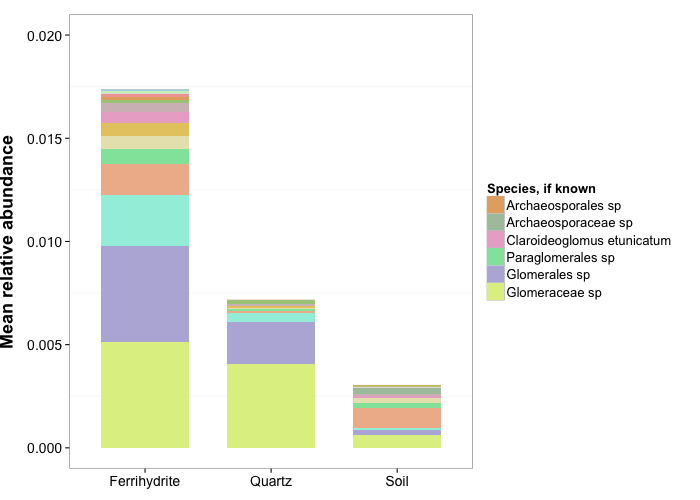

In [245]:
%%R -w 700 -h 500

totabund = 2000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Total=sum(Abundance))%>%
    filter(Phylum=="Glomeromycota")%>%
    filter(sum(Abundance)>0)%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    mutate(relabund = Abundance / Total)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, d.plot$OTU, paste(d.plot$Species))
d.plot = d.plot %>%
    group_by(Sample,Species,Trtmt,Month) %>%
    summarize(relabund=sum(relabund)) %>%
    group_by(Species,Trtmt)%>%
    summarize(relabund=mean(relabund))

colnames(d.plot) <- c("Tax", "Trtmt", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
lev = mean.Abund[order(-mean.Abund$M),]$Tax
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Month, scales = "free_y", space = "free")

N=12
Species=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
Species = Species[grepl("OTU",paste(Species))==FALSE]

p = p + scale_fill_manual(values = colors,breaks=Species)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + ylim(0,0.02)

p = p + guides(fill = guide_legend(title="Species, if known", ncol = 1, reverse=TRUE))

p = p + theme_bw() + labs(y="Relative abundance of total sample")
p = p + ylab("Mean relative abundance")
p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=14), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())

p

In [246]:
%%R
ggsave(filename="RelabundGlomNOSH.jpg", p, width=10, height=6)

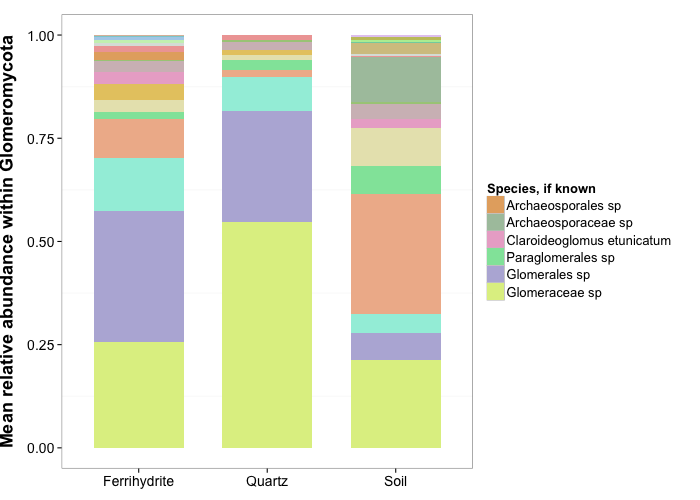

In [247]:
%%R -w 700 -h 500

totabund = 2000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    filter(sum(Abundance)>0)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, d.plot$OTU, paste(d.plot$Species))
d.plot = d.plot %>%
    mutate(abund.insample = Abundance / sum(Abundance))%>%
    group_by(OTU,Trtmt,Species) %>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Trtmt,Species) %>%
    summarize(relabund=sum(mean.relabund))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

d.plot$Tax = factor(d.plot$Tax, levels=lev)
# Order the Phyla by abundance
#.plot$Month = factor(d.plot$Month)
#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

N=12
Species=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
Species = Species[grepl("OTU",paste(Species))==FALSE]

p = p + scale_fill_manual(values = colors, breaks=Species)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title = "Species, if known", ncol = 1, reverse=TRUE))

p = p + theme_bw() + labs(y="Mean relative abundance within Glomeromycota")
p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=14), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())

p

In [248]:
%%R
ggsave(filename="RelabundGlomOnlyNOSH.jpg", p, width=10, height=6)

###Making soil-only stacked bar to illustrate weird Emmonsia sample

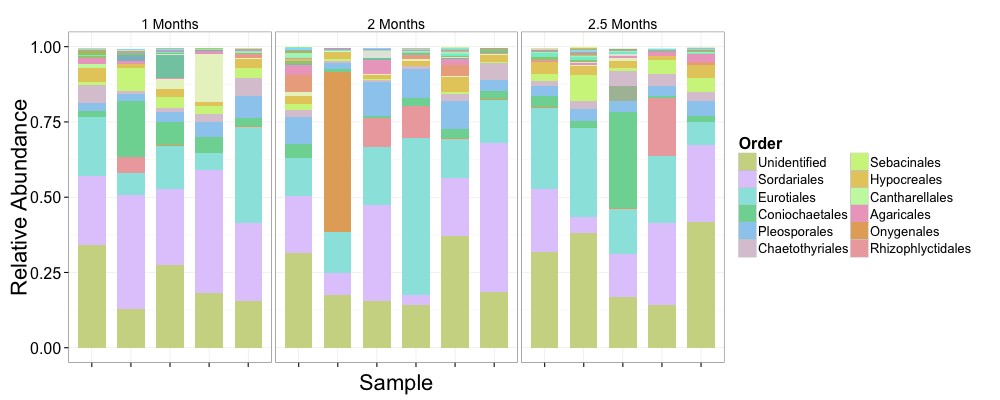

In [13]:
%%R -w 1000 -h 400

cutoff = 0.001
totabund = 1

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, "Unidentified", paste(d.plot$Order))
d.plot$Order = ifelse(d.plot$Order=="unidentified", "Unidentified", paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Sample, Order, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
#    filter(Month == 2.5) %>%
    filter(Trtmt == "Soil") %>%
    arrange(Trtmt)



colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

d.plot$MonthName = ifelse(d.plot$Month==2,"1 Months",(ifelse(d.plot$Month==2.5, "2 Months","2.5 Months")))
d.plot$MonthName = paste(d.plot$MonthName)
# Creates a "strip" column of d with Months

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~MonthName, scales = "free_x", space = "free")

N=10
Breaks=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
Breaks[[length(Breaks)+1]] <- "Onygenales"
Breaks[[length(Breaks)+1]] <- "Rhizophlyctidales"
p = p + scale_fill_manual("Order", values = colors, breaks = Breaks)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 2))

p = p + theme_bw()

p = p + theme(
    axis.text.x = element_blank(), 
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=16),
    strip.background = element_blank(),strip.text = element_text(size=14),
    axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
    axis.title.x = element_text(size = 22),
    axis.text.y = element_text(size=16),
    axis.title.y = element_text(size = 22))

p = p + labs(y = "Relative Abundance")

p

In [14]:
%%R
ggsave(filename="StackBarOrderAnomaly.jpg", plot=p ,width=8, height=4)

In [103]:
%%R
d.plot[d.plot$Tax=="Onygenales",]

Source: local data frame [13 x 6]

     Sample        Tax        Trtmt Month   Abundance  MonthName
1    Q_2_33 Onygenales       Quartz   2.0 0.001266336   1 Months
2    S_2_31 Onygenales         Soil   2.0 0.002591507   1 Months
3     S_2_9 Onygenales         Soil   2.0 0.001240866   1 Months
4  F_2.5_42 Onygenales Ferrihydrite   2.5 0.002344273 1.5 Months
5  Q_2.5_13 Onygenales       Quartz   2.5 0.001096534 1.5 Months
6  Q_2.5_27 Onygenales       Quartz   2.5 0.002098352 1.5 Months
7  Q_2.5_49 Onygenales       Quartz   2.5 0.001728059 1.5 Months
8  S_2.5_14 Onygenales         Soil   2.5 0.529992370 1.5 Months
9   S_2.5_3 Onygenales         Soil   2.5 0.004756243 1.5 Months
10 S_2.5_49 Onygenales         Soil   2.5 0.002195694 1.5 Months
11   F_3_22 Onygenales Ferrihydrite   3.0 0.001433332   2 Months
12   S_3_12 Onygenales         Soil   3.0 0.004643827   2 Months
13   S_3_22 Onygenales         Soil   3.0 0.002537868   2 Months


###Glomero stuff for Anne

In [23]:
%%R
d = mdf %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Trtmt=="Soil")%>%
    group_by(OTU,Phylum,Class,Order,Family,Genus,Species)%>%
    summarise()
d

Source: local data frame [60 x 7]
Groups: OTU, Phylum, Class, Order, Family, Genus

        OTU        Phylum          Class           Order               Family
1  OTU_1005 Glomeromycota Glomeromycetes      Glomerales          Glomeraceae
2   OTU_102 Glomeromycota Glomeromycetes      Glomerales          Glomeraceae
3  OTU_1043 Glomeromycota Glomeromycetes Archaeosporales                   NA
4  OTU_1109 Glomeromycota Glomeromycetes  Paraglomerales         unidentified
5  OTU_1111 Glomeromycota Glomeromycetes      Glomerales          Glomeraceae
6  OTU_1128 Glomeromycota Glomeromycetes      Glomerales Claroideoglomeraceae
7  OTU_1140 Glomeromycota Glomeromycetes  Paraglomerales         unidentified
8  OTU_1229 Glomeromycota Glomeromycetes Archaeosporales     Archaeosporaceae
9  OTU_1333 Glomeromycota Glomeromycetes      Glomerales          Glomeraceae
10 OTU_1366 Glomeromycota Glomeromycetes      Glomerales          Glomeraceae
..      ...           ...            ...             ...  

In [54]:
%%R
d = mdf %>%
    filter(Trtmt=="Soil")%>%
    filter(Phylum=="Glomeromycota")%>%
    select(Species,OTU)%>%
    group_by(Species)%>%
    summarise(Count=n_distinct(OTU))
d

Source: local data frame [11 x 2]

                      Species Count
1         Archaeosporaceae sp     6
2          Archaeosporales sp     2
3  Claroideoglomus etunicatum     1
4            Entrophospora sp     1
5       Funneliformis mosseae     4
6              Glomeraceae sp    21
7               Glomerales sp     4
8            Glomeromycota sp     1
9           Paraglomerales sp     6
10 uncultured Archaeosporales     1
11                         NA    13


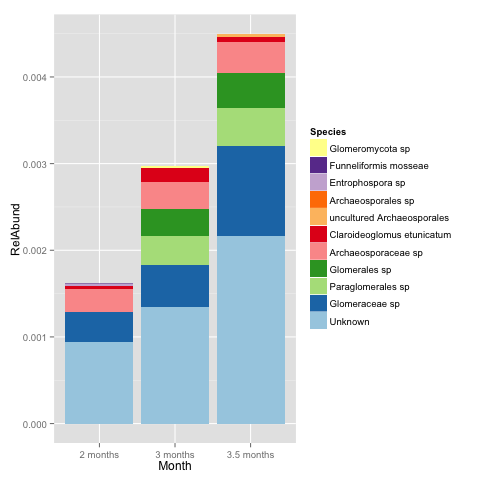

In [176]:
%%R

cutoff = 0
totabund = 1200

d.plot = mdf

d.plot$Month = ifelse(d.plot$Month==2,"2 months",ifelse(d.plot$Month==2.5,"3 months","3.5 months"))
d.plot$Month = as.factor(d.plot$Month)

d.plot = d.plot %>%
    filter(Trtmt == "Soil") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))

d.plot = d.plot %>%
    filter(Phylum=="Glomeromycota")%>%
    # Includes only the Glomeromycota
    group_by(Month, Species, OTU) %>%
    summarize(Abundance = mean(Abundance))%>%
    # Gets the mean abundance of each OTU, for each month
    group_by(Month,Species)%>%
    summarize(RelAbund = sum(Abundance))%>%
    arrange(Month,-RelAbund)%>%
    mutate(Species=ifelse(is.na(Species),"Unknown",paste(Species)))

d.plot$Species <- factor(d.plot$Species, levels = ordered(d.plot$Species[d.plot$Month=="3.5 months"][1:11]))

p = ggplot(d.plot,aes(x=Month,y=RelAbund,fill=Species))
p = p + geom_bar(stat="identity")
p = p + guides(fill=guide_legend(reverse=TRUE))
p = p + scale_fill_brewer(palette="Paired")
p

###Looking for plant DNA

In [6]:
%%R
mdf

            OTU   Sample Abundance Cosm Month          Trtmt  Kingdom
152615    OTU_9   F_3_44     42350   44   3.0   Ferrihydrite    Fungi
128490    OTU_6   F_3_44     40179   44   3.0   Ferrihydrite    Fungi
79843     OTU_2   Q_3_12     35804   12   3.0         Quartz    Fungi
14        OTU_1   S_2_33     35197   33   2.0           Soil    Fungi
104491    OTU_3 S_2.5_14     32608   14   2.5           Soil    Fungi
120480    OTU_5 S_2.5_49     28529   49   2.5           Soil    Fungi
24058    OTU_13 F_2.5_27     23017   27   2.5   Ferrihydrite    Fungi
144492    OTU_8   S_2_33     22287   33   2.0           Soil    Fungi
16200    OTU_12   Q_3_12     19221   12   3.0         Quartz    Fungi
112623    OTU_4 Q_2.5_49     17508   49   2.5         Quartz    Fungi
79       OTU_10 Q_2.5_49     16517   49   2.5         Quartz    Fungi
40104    OTU_15   F_2_28     15659   28   2.0   Ferrihydrite    Fungi
8058     OTU_11   S_2_33     14252   33   2.0           Soil    Fungi
128484    OTU_6   F_

In [14]:
%%R
plants_na = mdf %>%
    filter(is.na(Kingdom)==TRUE)
head(plants_na)

       OTU   Sample Abundance Cosm Month        Trtmt Kingdom Phylum Class
1   OTU_22 F_2.5_14     10673   14   2.5 Ferrihydrite    <NA>   <NA>  <NA>
2 OTU_1773 Q_2.5_49      8326   49   2.5       Quartz    <NA>   <NA>  <NA>
3   OTU_16 F_2.5_27      8063   27   2.5 Ferrihydrite    <NA>   <NA>  <NA>
4   OTU_44 F_2.5_14      6583   14   2.5 Ferrihydrite    <NA>   <NA>  <NA>
5   OTU_14 F_2.5_49      6382   49   2.5 Ferrihydrite    <NA>   <NA>  <NA>
6   OTU_38   S_3_44      5331   44   3.0         Soil    <NA>   <NA>  <NA>
  Order Family Genus Species      Rank1
1  <NA>   <NA>  <NA>    <NA> Unassigned
2  <NA>   <NA>  <NA>    <NA> Unassigned
3  <NA>   <NA>  <NA>    <NA> Unassigned
4  <NA>   <NA>  <NA>    <NA> Unassigned
5  <NA>   <NA>  <NA>    <NA> Unassigned
6  <NA>   <NA>  <NA>    <NA> Unassigned


In [15]:
%%R
plants_na

           OTU   Sample Abundance Cosm Month          Trtmt Kingdom Phylum
1       OTU_22 F_2.5_14     10673   14   2.5   Ferrihydrite    <NA>   <NA>
2     OTU_1773 Q_2.5_49      8326   49   2.5         Quartz    <NA>   <NA>
3       OTU_16 F_2.5_27      8063   27   2.5   Ferrihydrite    <NA>   <NA>
4       OTU_44 F_2.5_14      6583   14   2.5   Ferrihydrite    <NA>   <NA>
5       OTU_14 F_2.5_49      6382   49   2.5   Ferrihydrite    <NA>   <NA>
6       OTU_38   S_3_44      5331   44   3.0           Soil    <NA>   <NA>
7       OTU_14 F_2.5_27      5180   27   2.5   Ferrihydrite    <NA>   <NA>
8       OTU_32 S_2.5_49      5057   49   2.5           Soil    <NA>   <NA>
9       OTU_79 Q_2.5_49      4828   49   2.5         Quartz    <NA>   <NA>
10      OTU_33 Q_2.5_49      4801   49   2.5         Quartz    <NA>   <NA>
11      OTU_22 Q_2.5_49      4791   49   2.5         Quartz    <NA>   <NA>
12      OTU_14   F_2_33      4782   33   2.0   Ferrihydrite    <NA>   <NA>
13      OTU_18 F_2.5_49  

In [24]:
%%R
print(paste("mdf",dim(mdf)[1]))
print(paste("protists",dim(plants)[1]))
print(paste("NA",dim(plants_na)[1]))

[1] "mdf 160600"
[1] "protists 219"
[1] "NA 73365"


In [37]:
%%R
length(levels(as.factor(mdf$OTU)))

[1] 2200


In [38]:
!grep "OTU_14" -2 "../../SeqData/ITS.otus.fasta"

CAACCCTCAAGCCCTGCTTGGTGTTGGGGCCCTACGGCTGCCGTAGGCCCTGAAAGGAAGTGGCGGGGCTCGCTGCAACT
CCGAGCGTAGTAGAATCCTATCTCGCTAGGGAGGCGCGGCGCGCTCCAGCCGTTAAAGACCCCATCTTTAACCAA
>OTU_14
ACAACAATCAAGCTCAGCTTGTTGTTGGAAGTGGCCCTTTCTTCGGAGGGGACCTTTCCAAAACTCATGGGCGCCGCCGT
CCGGCTCCAAGCGTAGCAAGCGAAAGCCCTCGTCTTGGATCGTCGGATCGTTGGCCGCCGGTAAACCTCTGGGGCAACCC
--
--
GACCCTTCAAGCTCTGCTTGGTGTTGGGCGTTTGTTCCGCCTCCGCGCGTGGACTCGCCTCAAATTCATTGGCAGCCGGC
AAGTTGGCTTCGTGCGCAGCACATTGCGTCACGGCTCCAGTCTGCCTCCGTCCAGTAAGGCTCCTCATCA
>OTU_140
CTGCCCATCAAGCCCGGCTTGTGTGTTGGGTCGTCGTCCCCCCCGGGGGACGGGCCCGAAAGGCAGCGGCGGCACCGTGT
CCGGTCCTCGAGCGTATGGGGCTTTGTCACCCGCTCGATTTAGGGCCGGCCGGGCGCCAGCCGACGTCCAACCATTTTTC
--
--
CCGGTCCTCGAGCGTATGGGGCTTTGTCACCCGCTCGATTTAGGGCCGGCCGGGCGCCAGCCGACGTCCAACCATTTTTC
TTCA
>OTU_141
CAACCATCAAGCCCTAGGCTTGTGTTGGGGCCCTGCGGCCGTCCGCAGCCCCCTAAAAACAGTGGCGGGCTCGCTATATA
CCGAGTGCAGTAGTTTACTCTTCGCTCAGGACATGTAGTGGGTTCTTGCCGTAAAACCCCCCATTTATCAA
--
--
CAACCATCAAGCCCTAGGCTTGTGTTGGGGCCCTGCGGCCGTCCGCAGCCCCCTAAAAACAGTGGCGGGCTCGCTATATA
CCG

###Looking at sequences that were not matched in ITSx

In [46]:
!head -60 "../../SeqData/ITS.demult.maxee.homoP.usearch.unique.sorted.output_no_detections.fasta"

>72_890;barcodelabel=72;size=1074;
CAGTGAATCATCGAGTCTTTGCTTGGCATATCAATAAGCGGAGGATCTTA
>74_1030;barcodelabel=74;size=1064;
CAGTGAATCATCGAATCTTTGCTTGGCATATCAATAAGCGGAGGATCTTA
>72_2793;barcodelabel=72;size=1047;
CAGTGAGTCATCGAGTCTTTGCTTGGCATATCAATAAGCGGAGGATCTTA
>74_365;barcodelabel=74;size=1037;
CAGTGAGTCATCGAATCTTTGCTTGGCATATCAATAAGCGGAGGATCTTA
>5_1681;barcodelabel=5;size=1000;
TCACTCAGTGAATCATCGAATCTTTGAACGCAAGTGGCGACGGTTTCGGCCGTCATGTTTGTTTCAGTGTGTTCGGTTAATTGCATCGTAGAATTTAATGTGACTGAAGCAATTCTTTCACTTAATACGAAGCAATGTCAGCTAAAGGACATTAAGCGAACTTGTCACTAATTGGTGGTAATCGTTTAAGTGTTGTTAGTTGTAAATCGTTGCTTAATAAAAAATTATCCAATCATAACACCTGAAAGAAGCAAGAATACCCGCTGAACTTAAGCATATCAATAAGCGGAGGA
>5_107;barcodelabel=5;size=842;
TCACTCAGTGAATCATCGAGTCTTTGAACGCAAGTGGCGACGGTTTCGGCCGTCATGTTTGTTTCAGTGTGTTCGGTTAATTGCATCGTAGAATTTAATGTGACTGAAGCAATTCTTTCACTTAATACGAAGCAATGTCAGCTAAAGGACATTAAGCGAACTTGTCACTAATTGGTGGTAATCGTTTAAGTGTTGTTAGTTGTAAATCGTTGCTTAATAAAAAATTATCCAATCATAACACCTGAAAGAAGCAAGAATACCCGCTGAACTTAAGCATATCAATAAGCGGAGGA


###Looking for Mortierella for Nhu

In [6]:
%%R
head(mdf)

         OTU   Sample Abundance Cosm Month        Trtmt Kingdom        Phylum
152615 OTU_9   F_3_44     42350   44   3.0 Ferrihydrite   Fungi Basidiomycota
128490 OTU_6   F_3_44     40179   44   3.0 Ferrihydrite   Fungi Basidiomycota
79843  OTU_2   Q_3_12     35804   12   3.0       Quartz   Fungi    Ascomycota
14     OTU_1   S_2_33     35197   33   2.0         Soil   Fungi    Ascomycota
104491 OTU_3 S_2.5_14     32608   14   2.5         Soil   Fungi    Ascomycota
120480 OTU_5 S_2.5_49     28529   49   2.5         Soil   Fungi    Ascomycota
                 Class       Order              Family        Genus
152615  Agaricomycetes Sebacinales        unidentified unidentified
128490  Agaricomycetes Sebacinales Sebacinales Group B  Serendipita
79843   Eurotiomycetes  Eurotiales      Trichocomaceae  Talaromyces
14     Sordariomycetes Sordariales   Lasiosphaeriaceae    Podospora
104491  Eurotiomycetes  Onygenales    Ajellomycetaceae     Emmonsia
120480 Sordariomycetes Sordariales   Lasiospha

In [35]:
%%R
Soils = mdf %>%
    filter(Trtmt == "Soil")%>%
    group_by(Sample)%>%
    mutate(Sum=sum(Abundance))%>%
    group_by(Order)%>%
    filter(Order=="Mortierellales")%>%
    mutate(Mort=sum(Abundance))%>%
    mutate(FractMort=Mort/Sum)%>%
    select(Sample,Order,FractMort)%>%
    distinct(Sample)
Soils

Source: local data frame [16 x 3]
Groups: Order

     Sample          Order  FractMort
1    S_2_31 Mortierellales 0.03001406
2    S_3_22 Mortierellales 0.03541026
3    S_3_12 Mortierellales 0.07763077
4    S_2_15 Mortierellales 0.03339993
5  S_2.5_49 Mortierellales 0.01888723
6  S_2.5_27 Mortierellales 0.09168995
7    S_3_20 Mortierellales 0.22345523
8   S_2.5_3 Mortierellales 0.14046770
9    S_2_33 Mortierellales 0.01175300
10   S_3_44 Mortierellales 0.08152374
11 S_2.5_14 Mortierellales 0.02876670
12   S_3_23 Mortierellales 0.04406645
13 S_2.5_16 Mortierellales 0.02423878
14   S_2_28 Mortierellales 0.08759268
15    S_2_9 Mortierellales 0.24431270
16 S_2.5_13 Mortierellales 9.13402062


In [44]:
%%R
Soils2 = mdf %>%
    filter(Sample=="S_3_23")
SumTot = sum(Soils2$Abundance)
Mort = Soils2 %>%
    filter(Order=="Mortierellales")
SumMort = sum(Mort$Abundance)
FractMort = SumMort/SumTot
FractMort

[1] 0.001069333


In [54]:
%%R
cutoff = 0
totabund = 1200

d.plot = mdf %>%
#    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))%>%
    mutate(PhylumLetter = substring(Phylum,1,1))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, ifelse(d.plot$OTU=="OTU_14","OTU X","Unidentified"), paste(d.plot$Order))
d.plot$Order = ifelse(d.plot$Order=="unidentified"|d.plot$Order=="Incertae sedis", "Unidentified", paste(d.plot$Order))
d.plot$Order = paste(d.plot$Order,"(",d.plot$PhylumLetter,")")

d.plot = d.plot %>%
    group_by(Trtmt,Month, Order, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Order) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Order)%>%
    summarize(Abundance = mean(Abundance))

head(d.plot[d.plot$Order=="Mortierellales ( Z )",])


Source: local data frame [4 x 3]
Groups: Trtmt

         Trtmt                Order   Abundance
1 Ferrihydrite Mortierellales ( Z ) 0.003942744
2    Kaolinite Mortierellales ( Z ) 0.006461784
3       Quartz Mortierellales ( Z ) 0.010779479
4         Soil Mortierellales ( Z ) 0.003655705
